<a href="https://colab.research.google.com/github/skywalker0803r/AlphaCoin/blob/main/%E5%BE%9E%E9%9B%B6%E9%96%8B%E5%A7%8B%E7%8D%A8%E8%87%AA%E7%A0%94%E7%99%BC%E7%82%92%E5%B9%A3%E7%A8%8B%E5%BC%8F%E7%AC%AC%E5%9B%9B%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 定義SVM模型

In [1]:
from abc import ABC
import pandas as pd
from sklearn.svm import SVC
from typing import Optional
import joblib
import os

class BaseStrategy(ABC):
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.signals: Optional[pd.Series] = None

    def get_signals(self) -> pd.Series:
        return self.signals

    def generate_signals(self):
        raise NotImplementedError("Subclasses must implement generate_signals()")


class SvmStrategy(BaseStrategy):
    def __init__(self, data: pd.DataFrame, feature_cols: list[str]):
        super().__init__(data)
        self.feature_cols = feature_cols
        self.model: Optional[SVC] = None

    def fit(self, train_data: pd.DataFrame, label_col: str):
        X = train_data[self.feature_cols]
        y = train_data[label_col]

        self.model = SVC(probability=True, random_state=42)
        self.model.fit(X, y)
        print("模型訓練完成")

    def generate_signals(self):
        if self.model is None:
            raise ValueError("Model not fitted. Call `fit` first.")

        X_pred = self.data[self.feature_cols]
        preds = self.model.predict(X_pred)

        self.signals = pd.Series(index=self.data.index, dtype="object")
        self.signals[:] = ['buy' if p == 1 else 'sell' for p in preds]
        print("交易信號產生完成")

    def save_model(self, path: str):
        if self.model is None:
            raise ValueError("Model not fitted. Cannot save.")

        joblib.dump(self.model, path)
        print(f"模型已儲存至: {path}")

    def load_model(self, path: str):
        if not os.path.exists(path):
            raise FileNotFoundError(f"找不到模型檔案: {path}")

        self.model = joblib.load(path)
        print(f"模型已從 {path} 載入成功")

# 定義回測函數

In [2]:
import pandas as pd
import numpy as np

def backtest_strategy(strategy,
                      data: pd.DataFrame,
                      initial_cash: float,
                      start_date: str,
                      end_date: str,
                      fee_rate: float = 0.001,
                      risk_free_rate: float = 0.0) -> dict:
    # 1.根據策略產生訊號
    strategy.generate_signals()
    signals = strategy.get_signals().copy()
    data = data.loc[start_date:end_date].copy()
    signals = signals.loc[start_date:end_date]

    # 2.初始化變量
    position = 0
    cash = initial_cash
    asset_curve = []
    trade_log = []
    entry_price = 0

    # 3.對訊號做遍歷
    for date, signal in signals.items():
        price = data.loc[date, 'close']

        # 4.買入時紀錄
        if signal == 'buy' and position == 0:
            position = cash * (1 - fee_rate) / price
            entry_price = price
            cash = 0
            trade_log.append({
                'entry_date': date,
                'entry_price': price,
                'exit_date': None,
                'exit_price': None,
                'return': None,
                'holding_days': None
            })

        # 5.賣出時紀錄
        elif signal == 'sell' and position > 0:
            exit_price = price
            cash = position * exit_price * (1 - fee_rate)
            ret = (exit_price - entry_price) / entry_price
            holding_days = (date - trade_log[-1]['entry_date']).days

            trade_log[-1].update({
                'exit_date': date,
                'exit_price': exit_price,
                'return': ret,
                'holding_days': holding_days
            })

            position = 0
            entry_price = 0

        total_value = cash + position * price
        asset_curve.append((date, total_value))

    # 6.若遍歷完訊號還有部位沒結算則結算
    if position > 0:
        price = data.iloc[-1]['close']
        cash = position * price * (1 - fee_rate)
        ret = (price - entry_price) / entry_price
        holding_days = (data.index[-1] - trade_log[-1]['entry_date']).days
        trade_log[-1].update({
            'exit_date': data.index[-1],
            'exit_price': price,
            'return': ret,
            'holding_days': holding_days
        })
        asset_curve.append((data.index[-1], cash))
        position = 0

    # 計算returns
    asset_df = pd.DataFrame(asset_curve, columns=['date', 'total_asset']).set_index('date')
    returns = asset_df['total_asset'].pct_change().dropna()

    buy_price = data.iloc[0]['close']
    shares_bought = initial_cash * (1 - fee_rate) / buy_price
    buy_and_hold_values = shares_bought * data['close'] * (1 - fee_rate)
    buy_and_hold_curve = buy_and_hold_values.to_frame(name='total_asset')

    trades_df = pd.DataFrame(trade_log)
    trades_df = trades_df[trades_df['return'].notna()]

    num_trades = len(trades_df)

    # 計算勝率
    win_rate = (trades_df['return'] > 0).sum() / num_trades if num_trades > 0 else 0

    avg_profit = trades_df[trades_df['return'] > 0]['return'].mean() if not trades_df[trades_df['return'] > 0].empty else 0
    avg_loss = trades_df[trades_df['return'] < 0]['return'].mean() if not trades_df[trades_df['return'] < 0].empty else 0

    profit_loss_ratio = avg_profit / abs(avg_loss) if avg_loss != 0 else np.nan
    pl_ratio_total = trades_df[trades_df['return'] > 0]['return'].sum() / abs(trades_df[trades_df['return'] < 0]['return'].sum()) \
                     if any(trades_df['return'] < 0) else np.nan

    expectancy = win_rate * avg_profit + (1 - win_rate) * avg_loss \
        if not np.isnan(avg_profit) and not np.isnan(avg_loss) else np.nan

    avg_holding_days = trades_df['holding_days'].mean() if 'holding_days' in trades_df.columns else np.nan

    final_asset = asset_df['total_asset'].iloc[-1]
    total_return = (final_asset - initial_cash) / initial_cash
    duration_years = (asset_df.index[-1] - asset_df.index[0]).days / 365.25
    cagr = (final_asset / initial_cash) ** (1 / duration_years) - 1 if duration_years > 0 else np.nan

    sharpe_ratio = ((returns.mean() - risk_free_rate / 252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else np.nan

    running_max = asset_df['total_asset'].cummax()
    drawdown = asset_df['total_asset'] / running_max - 1
    max_drawdown = drawdown.min()

    return {
        'asset_curve': asset_df,
        'buy_and_hold_curve': buy_and_hold_curve,
        'final_asset': final_asset,
        'total_return': total_return,
        'cagr': cagr,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'profit_loss_ratio_avg': profit_loss_ratio,
        'profit_loss_ratio_total': pl_ratio_total,
        'expectancy': expectancy,
        'avg_holding_days': avg_holding_days,
        'num_trades': num_trades,
        'avg_profit': avg_profit,
        'avg_loss': avg_loss,
        'trades': trades_df
    }


# 定義取得資料函數

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import ta

def get_data(start_date,end_data):
  df = yf.download("BTC-USD", start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))
  df.columns = [col[0].lower() for col in df.columns]  # 統一欄位名稱為小寫
  df['rsi_14'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
  stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
  df['stoch_k'] = stoch.stoch()
  atr = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14)
  df['atr_ratio'] = atr.average_true_range() / df['close']
  willr = ta.momentum.WilliamsRIndicator(high=df['high'], low=df['low'], close=df['close'], lbp=14)
  df['willr'] = willr.williams_r()
  df['target'] = (df['close'].shift(-1) > df['close']).astype(int)
  df.dropna(inplace=True)
  feature_cols = ['rsi_14', 'stoch_k', 'atr_ratio', 'willr']
  train_data = df.copy()
  pred_data = train_data.drop(columns=['target'])
  train_data[feature_cols + ['target']]
  return train_data,pred_data,feature_cols

# 取得2023到2024資料 並訓練模型

In [4]:
from datetime import datetime, timedelta
end_date = datetime.today() - timedelta(days=365)
start_date = datetime.today() - timedelta(days=365*2)
train_data,pred_data,feature_cols = get_data(start_date,end_date)
strategy = SvmStrategy(data=pred_data, feature_cols=feature_cols)
strategy.fit(train_data, label_col='target')
strategy.save_model('svm_model.pkl')
strategy.generate_signals()
signals = strategy.get_signals()
signals

C:\Users\ricky\AppData\Local\Temp\ipykernel_10108\4257915626.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))
[*********************100%***********************]  1 of 1 completed

模型訓練完成
模型已儲存至: svm_model.pkl
交易信號產生完成


Date
2023-07-20    buy
2023-07-21    buy
2023-07-22    buy
2023-07-23    buy
2023-07-24    buy
             ... 
2024-07-01    buy
2024-07-02    buy
2024-07-03    buy
2024-07-04    buy
2024-07-05    buy
Length: 352, dtype: object

# 觀察模型在2023到2024的表現

[*********************100%***********************]  1 of 1 completed


模型已從 svm_model.pkl 載入成功
交易信號產生完成
總報酬率: 63.37%
年化報酬率: 66.66%
夏普比率: 1.42
最大回撤: -18.73%
勝率: 82.86%
平均盈虧比: 0.60
總盈虧比: 2.92
期望值: 0.0172
平均持倉日: 5.23
總交易次數: 35


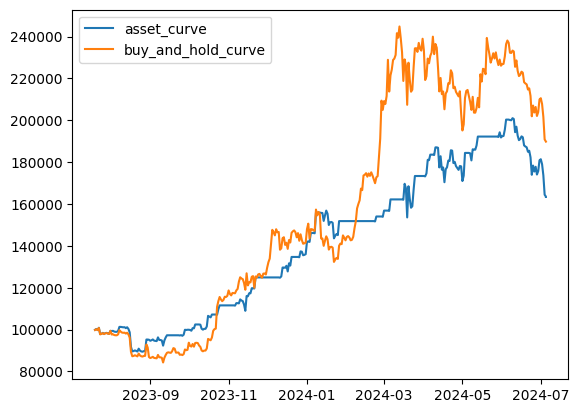

,entry_date,entry_price,exit_date,exit_price,return,holding_days
0,2023-07-20,29792.015625,2023-08-01,29675.732422,-0.003903,12
1,2023-08-02,29151.958984,2023-08-08,29765.492188,0.021046,6
2,2023-08-10,29429.591797,2023-08-29,27727.392578,-0.057840,19
3,2023-08-31,25931.472656,2023-09-14,26539.673828,0.023454,14
4,2023-09-24,26256.826172,2023-09-28,27021.546875,0.029125,4
5,2023-09-29,26911.720703,2023-09-30,26967.916016,0.002088,1
6,2023-10-02,27530.785156,2023-10-04,27799.394531,0.009757,2
7,2023-10-05,27415.912109,2023-10-06,27946.597656,0.019357,1
8,2023-10-10,27391.019531,2023-10-19,28719.806641,0.048512,9
9,2023-10-23,33086.234375,2023-10-25,34502.820312,0.042815,2


In [5]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
initial_cash=100000
end_date = datetime.today() - timedelta(days=365)
start_date = datetime.today() - timedelta(days=365*2)
train_data,pred_data,feature_cols = get_data(start_date,end_date)
strategy = SvmStrategy(data=pred_data, feature_cols=feature_cols)
strategy.load_model('svm_model.pkl')
result = backtest_strategy(strategy=strategy, data=pred_data,initial_cash=initial_cash,start_date=start_date.strftime("%Y-%m-%d"),end_date=end_date.strftime("%Y-%m-%d"))
print(f"總報酬率: {result['total_return']:.2%}")
print(f"年化報酬率: {result['cagr']:.2%}")
print(f"夏普比率: {result['sharpe_ratio']:.2f}")
print(f"最大回撤: {result['max_drawdown']:.2%}")
print(f"勝率: {result['win_rate']:.2%}")
print(f"平均盈虧比: {result['profit_loss_ratio_avg']:.2f}")
print(f"總盈虧比: {result['profit_loss_ratio_total']:.2f}")
print(f"期望值: {result['expectancy']:.4f}")
print(f"平均持倉日: {result['avg_holding_days']:.2f}")
print(f"總交易次數: {result['num_trades']}")
plt.plot(result['asset_curve'],label='asset_curve')
plt.plot(result['buy_and_hold_curve'],label='buy_and_hold_curve')
plt.legend()
plt.show()
result['trades']

# 觀察模型在2024到2025的表現

[*********************100%***********************]  1 of 1 completed


模型已從 svm_model.pkl 載入成功
交易信號產生完成
總報酬率: 32.35%
年化報酬率: 33.87%
夏普比率: 0.81
最大回撤: -19.28%
勝率: 64.29%
平均盈虧比: 1.34
總盈虧比: 2.42
期望值: 0.0127
平均持倉日: 5.86
總交易次數: 28


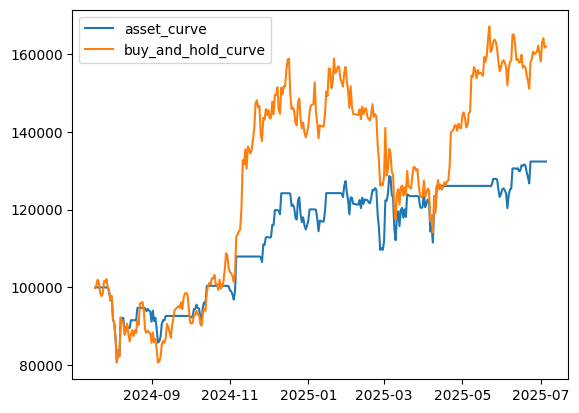

,entry_date,entry_price,exit_date,exit_price,return,holding_days
0,2024-07-29,66819.914062,2024-08-08,61710.136719,-0.076471,10
1,2024-08-09,60880.113281,2024-08-12,59354.515625,-0.025059,3
2,2024-08-15,57560.097656,2024-08-16,58894.105469,0.023176,1
3,2024-08-20,59012.792969,2024-08-21,61175.191406,0.036643,1
4,2024-08-27,59504.132812,2024-09-10,57648.710938,-0.031181,14
5,2024-09-11,57343.171875,2024-09-12,58127.011719,0.013669,1
6,2024-10-01,60837.007812,2024-10-14,66046.125000,0.085624,13
7,2024-10-31,70215.187500,2024-11-06,75639.078125,0.077247,6
8,2024-11-25,93102.296875,2024-11-27,95962.531250,0.030721,2
9,2024-11-28,95652.468750,2024-11-29,97461.523438,0.018913,1


In [6]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
initial_cash=100000
end_date = datetime.today()
start_date = datetime.today() - timedelta(days=365)
train_data,pred_data,feature_cols = get_data(start_date,end_date)
strategy = SvmStrategy(data=pred_data, feature_cols=feature_cols)
strategy.load_model('svm_model.pkl')
result = backtest_strategy(strategy=strategy, data=pred_data,initial_cash=initial_cash,start_date=start_date.strftime("%Y-%m-%d"),end_date=end_date.strftime("%Y-%m-%d"))
print(f"總報酬率: {result['total_return']:.2%}")
print(f"年化報酬率: {result['cagr']:.2%}")
print(f"夏普比率: {result['sharpe_ratio']:.2f}")
print(f"最大回撤: {result['max_drawdown']:.2%}")
print(f"勝率: {result['win_rate']:.2%}")
print(f"平均盈虧比: {result['profit_loss_ratio_avg']:.2f}")
print(f"總盈虧比: {result['profit_loss_ratio_total']:.2f}")
print(f"期望值: {result['expectancy']:.4f}")
print(f"平均持倉日: {result['avg_holding_days']:.2f}")
print(f"總交易次數: {result['num_trades']}")
plt.plot(result['asset_curve'],label='asset_curve')
plt.plot(result['buy_and_hold_curve'],label='buy_and_hold_curve')
plt.legend()
plt.show()
result['trades']